In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint


Using TensorFlow backend.


In [2]:
#Load Data
sample_submission = pd.read_csv("../input/histopathologic-cancer-detection/sample_submission.csv")
train_labels      = pd.read_csv("../input/histopathologic-cancer-detection/train_labels.csv")

train_dir         = "../input/histopathologic-cancer-detection/train/"
train_files       = os.listdir(train_dir)

test_dir          = "../input/histopathologic-cancer-detection/test/"
test_files        = os.listdir(test_dir)

In [3]:
#Inspect Labels
print(train_labels.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


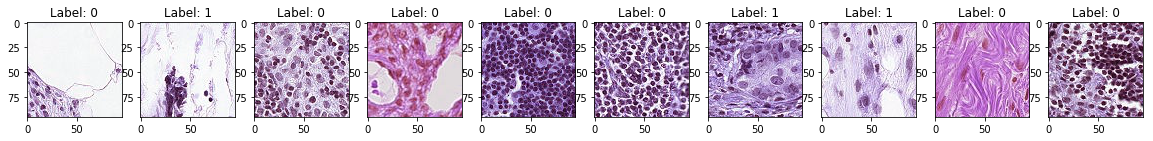

In [4]:
#Preview Images

nr_images = 10
    
fig, axs = plt.subplots(1, len(train_labels[:nr_images]), figsize = (20, 2))
for ii, ax in enumerate(axs):
    ax.imshow(cv2.imread(train_dir + train_labels.id[ii] + ".tif"))
    ax.set_title("Label: " + str(train_labels.label[ii]))


In [5]:
# Descriptive Analytics for given Dataset

print(train_labels.label.value_counts())

import plotly.graph_objects as go

labels = ["No Cancer - 0", "Cancer - 1"]
values = train_labels.label.value_counts()

donut = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.5, marker_colors=["rgb(217, 140, 217)", "rgb(96, 32, 96)"])])
donut.show()

0    130908
1     89117
Name: label, dtype: int64


In [6]:
def img_prep(directory, files, start = 0, end = -1, test=False):
    if end == -1:
        end = len(files)
    X = []
    if test:
        for image in files:
            img = cv2.imread( directory + image)
            #img = cv2.resize(img,(img_size,img_size))
            img = cv2.resize(img, (96, 96))
            X.append(img)
        print("Image shape: ",X[0].shape)
        X = np.array(X)
        return X
    else:
        for image in files.id[start:end]:
            img = cv2.imread( directory + image + ".tif")
            #img = cv2.resize(img,(img_size,img_size))
            img = cv2.resize(img, (96, 96))
            X.append(img)
        print("Image shape: ",X[0].shape)
        X = np.array(X)
    
    
        y = files.label[start:end]
        return X, y

In [ ]:
%%time

X_train, y_train = img_prep(train_dir, train_labels, start=10_000, end = 20_000)
#X_test, y_test  = img_prep(train_dir, train_labels, start= 200000, end=203000)

# Build CNN Model (3 * 3 w/ ascending filters)

In [ ]:
#Build CNN

model = Sequential()
model.add(Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=32, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = 3))

model.add(Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size = 3)) 

model.add(Conv2D(filters=128, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu'))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation = "sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
%%time

#Model Callbacks to reduce computation time
early_stopping = EarlyStopping(monitor = "val_loss", patience = 3)
checkpoint = ModelCheckpoint(filepath = "weights.hdf5", verbose=1, save_best_only=True)

#Model Training
history = model.fit(X_train, y_train, batch_size = 100, epochs = 20, validation_split=.2, callbacks = [early_stopping, checkpoint])

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# Image Augmentations

In [ ]:
#Define Image Augmentations (horizontal and vertical flip)
#Fit model on randomly augmented images

# from keras.preprocessing.image import ImageDataGenerator
# import gc

# sample_size = 10_000
# batch_size = 35
# epochs = 15

# early_stopping = EarlyStopping(monitor = "val_loss", patience = 3)
# checkpoint_aug = ModelCheckpoint(filepath = "aug_weights.hdf5", verbose=1, save_best_only=True)

# for x in range((len(train_labels)//sample_size) + 1):
    
#     gc.collect()
    
#     if x * sample_size > len(train_labels):
#         end = len(train_labels)
#     else:
#         start = x * sample_size
#         end = start + sample_size
    
#     X_train, y_train = img_prep(train_dir, train_labels, start = start, end = end)
    
#     full = len(X_train)

#     split_start = int(full * 0.8)
#     split_end = split_start + int(full * 0.2)
#     steps_per_ep = int(split_start / batch_size / epochs)

#     print("Train Samples:",split_start)
#     print("Validation Samples:",split_end - split_start)

#     # define data preparation
#     datagen_train = ImageDataGenerator(horizontal_flip=True,
#                                        vertical_flip=True)
#     datagen_train.fit(X_train)
#     gen_train = datagen_train.flow(X_train[:split_start], y_train[:split_start] , batch_size=batch_size)

#     datagen_val = ImageDataGenerator()
#     datagen_val.fit(X_train)
#     gen_val = datagen_val.flow(X_train[split_start:split_end], y_train[split_start:split_end])
    
#     if start == 0:
#         model.load_weights('../working/aug_weights.hdf5')

#     history_aug = model.fit_generator(
#         gen_train,
#         steps_per_epoch = steps_per_ep,
#         epochs = epochs,
#         validation_data = gen_val,
#         validation_steps = steps_per_ep,
#         callbacks = [early_stopping, checkpoint_aug])
    

In [ ]:
# # Plot training & validation accuracy values
# plt.plot(history_aug.history['accuracy'])
# plt.plot(history_aug.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='best')
# plt.show()

# # Plot training & validation loss values
# plt.plot(history_aug.history['loss'])
# plt.plot(history_aug.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='best')
# plt.show()

# Model Evaluation

In [ ]:
#Load best Model weights and evaluate on unseen data
#model.load_weights('../input/model-weights/weights (3).hdf5')
#model.evaluate(X_test, y_test)

In [ ]:
#Load Test Files and predict labels (used during model building and optimization)
test = img_prep(test_dir, test_files, test=True)
pred_test = model.predict(test)

# Create Submission File

In [ ]:
#Prepare Submission.csv file
lst = []
for item in test_files:
    lst.append(item[:-4])
    
test_df = pd.DataFrame(lst)
test_df.head()

In [ ]:
#Create Submission.csv file
predictions = np.array(pred_test)
test_df["label"] = predictions
test_df.columns = ["id", "label"]
submission = test_df

print(submission.head())
submission.to_csv("submission.csv", index = False, header = True)